In [39]:
import os

import numpy as np
from sklearn.manifold import TSNE
import pandas as pd

import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

----

In [40]:
# params
log_dir = "/logfiles"
model = "bigscience-T0_3B" # bigscience-T0_B or bigscience-T0
module = "encoder" # encoder or decoder
task = "rte"
# task = "cb"
# task = "wic"

## Prompts

In [46]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
display(df)

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No","0, 1",False
1,gpt_3_true_false_with_targets,{premise} Question: {hypothesis} True or False?,instructive,True,"▁True, ▁False","0, 1",False
2,gpt_3_cat_dog_with_targets,{premise} Question: {hypothesis} Cat or Dog?,instructive,True,"▁Cat, ▁Dog","0, 1",False
3,gpt_3_yes_no_without_targets,{premise} Question: {hypothesis}?,instructive,False,"▁Yes, ▁No","0, 1",False


In [47]:
# load prompted inputs and labels
df_inputs = {}
for _, row in df.iterrows():
    prompt = row['name']
    df_inputs[prompt] = pd.read_csv(f"/logfiles/{task}/{model}/{module}/{prompt}/prompted_samples.csv", sep='\t', index_col=0)


In [48]:
df_inputs['gpt_3_yes_no_with_targets'].head()

,input,label,prediction
0,"Dana Reeve, the widow of the actor Christopher...",not_entailment,not_entailment
1,"Yet, we now are discovering that antibiotics a...",entailment,not_entailment
2,Cairo is now home to some 15 million people - ...,not_entailment,not_entailment
3,"The Amish community in Pennsylvania, which num...",not_entailment,not_entailment
4,Security forces were on high alert after an el...,entailment,not_entailment


In [49]:
# load decoded predictions
df_outputs = {}
for _, row in df.iterrows():
    prompt = row['name']
    df_outputs[prompt] = pd.read_csv(f"/logfiles/{task}/{model}/{module}/{prompt}/decoded_predictions.csv", sep='\t', names=['predicitons'])

In [50]:
df_outputs['gpt_3_yes_no_with_targets'].head()

,predicitons
0,"['<pad>', '▁No', '</s>']"
1,"['<pad>', '▁No', '</s>']"
2,"['<pad>', '▁No', '</s>']"
3,"['<pad>', '▁No', '</s>']"
4,"['<pad>', '▁No', '</s>']"


## Plot t-SNE embeddings

In [51]:
if task == 'rte':
    use_pattern = [
        "gpt_3_yes_no_with_targets",
        "gpt_3_true_false_with_targets",
        "gpt_3_cat_dog_with_targets",
        "gpt_3_yes_no_without_targets",
    ]
elif task == 'cb':
    use_pattern = [
        "null_pattern",
        "null_pattern_reversed",
        "gpt_3_true_false_neither",
        "gpt_3_yes_no_maybe",
        "mnli_crowdsource",
        "always_sometimes_never",
        "based_on_previous_passage",
        "infer",
        "claim",
        "consider",
        "follow",
        "imply",
        "guaranteed",
        "guaranteed_possible",
        "justified",
        "must_be_true",
        "should_assume",
        "take_the_following",
    ]
elif task == 'wic':
    use_pattern = [
        "gpt_3",
        "gpt_3_yes_no",
        "affirmation",
        "grammar_homework",
        "polysemous",
        "question_context",
        "question_meaning",
        "question_meaning_yes_no",
        "same_sense",
        "similar_sense",
        "similar_sense_yes_no",
    ]

In [52]:
# use either ground-truth or predicted label for marker size
# marker_size = 'ground-truth'
marker_size = 'predicted'

(1108, 2048)


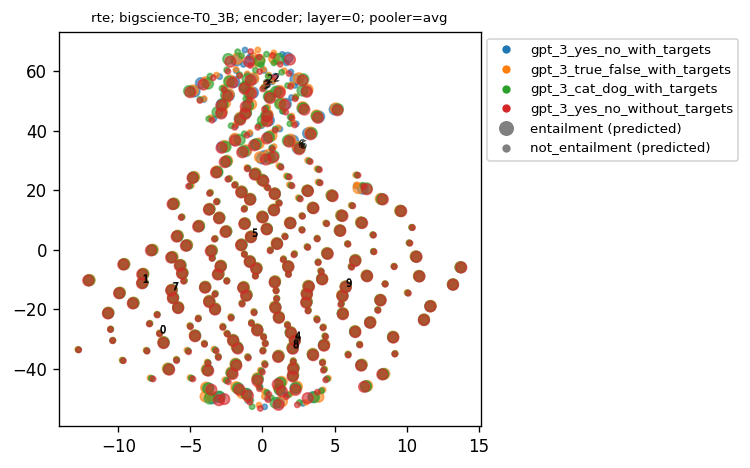

(1108, 2048)


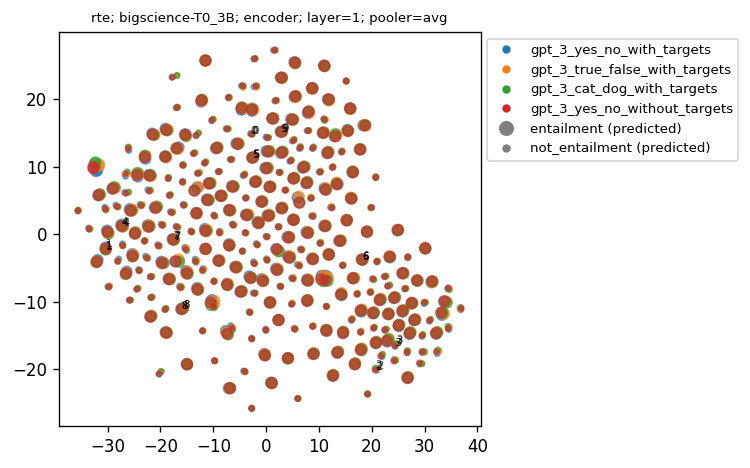

(1108, 2048)


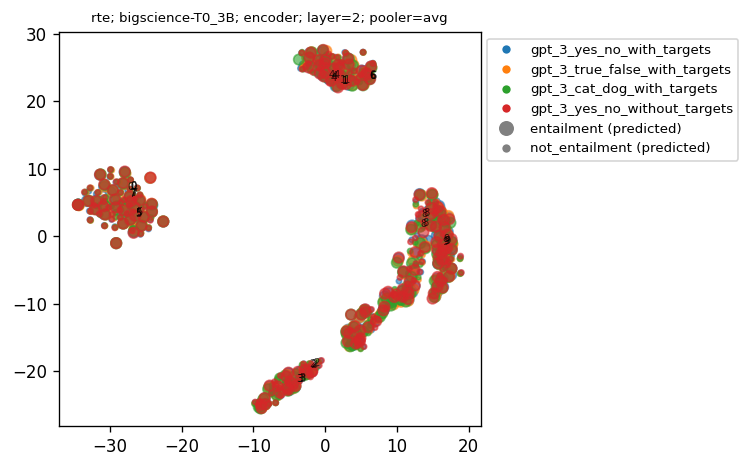

(1108, 2048)


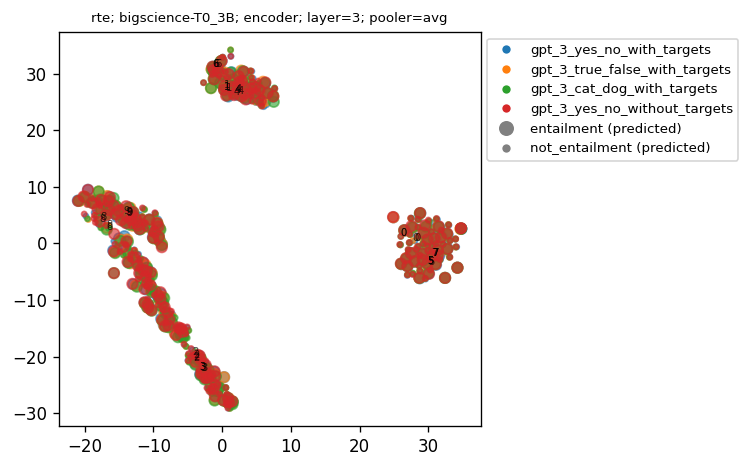

(1108, 2048)


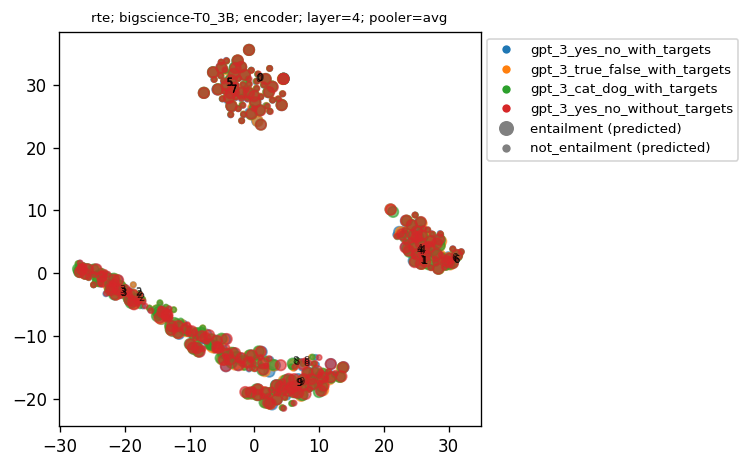

(1108, 2048)


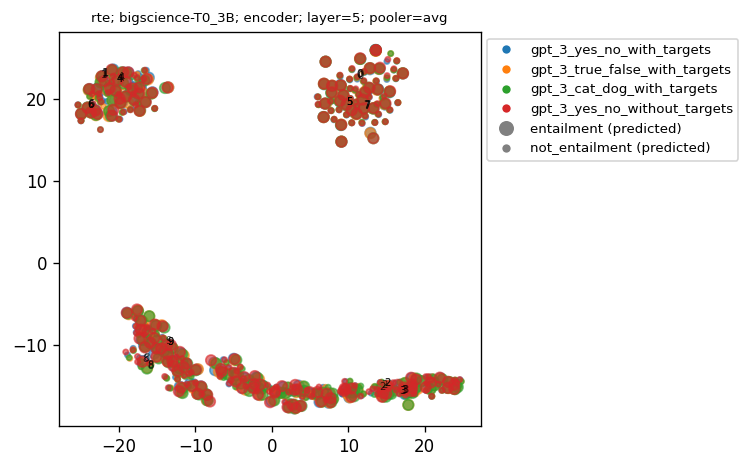

(1108, 2048)


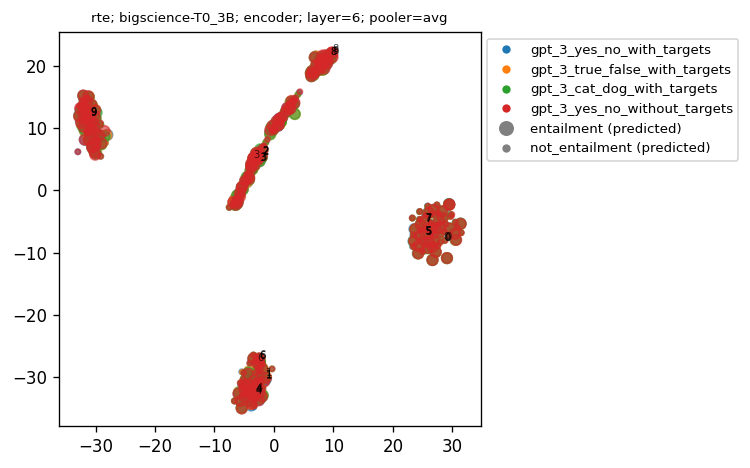

(1108, 2048)


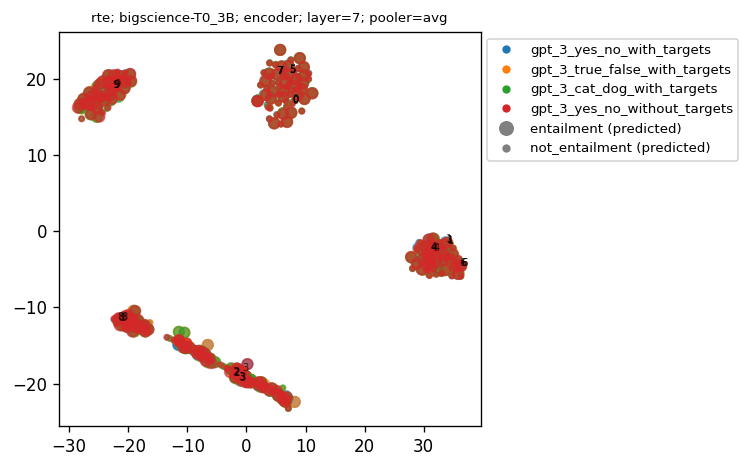

(1108, 2048)


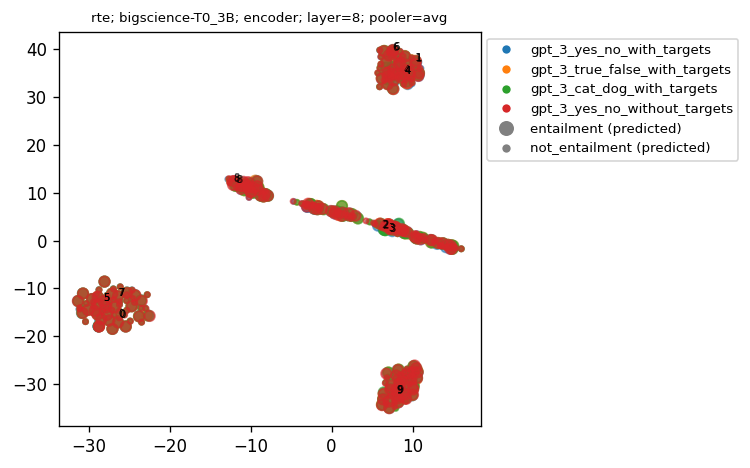

(1108, 2048)


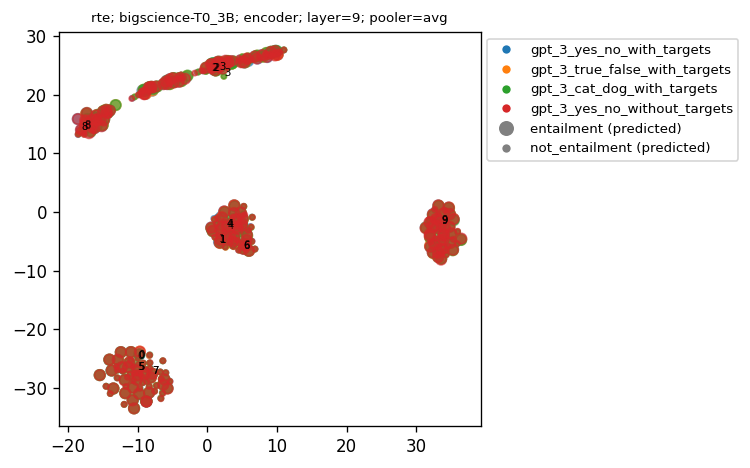

(1108, 2048)


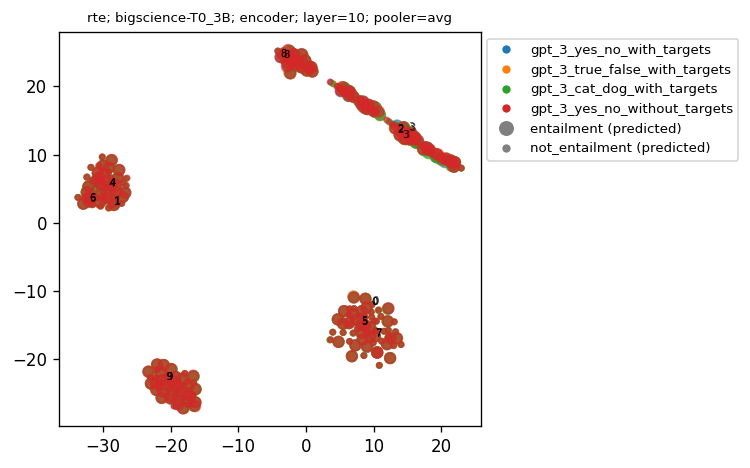

(1108, 2048)


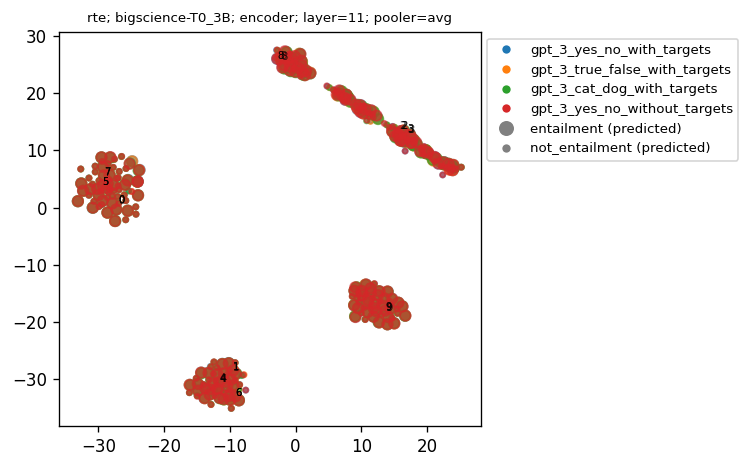

(1108, 2048)


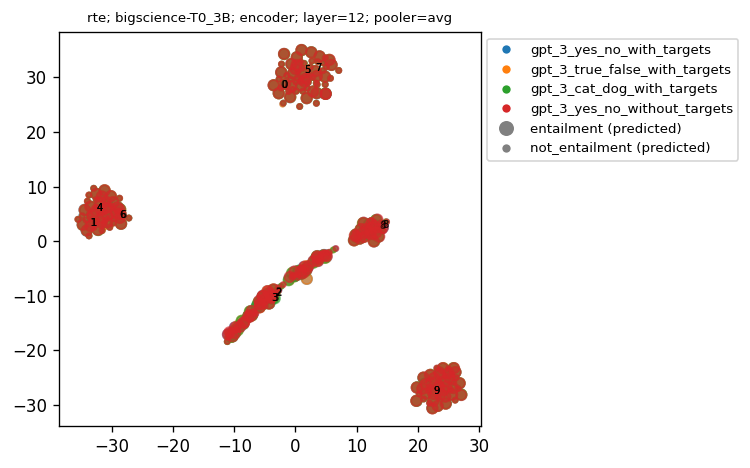

(1108, 2048)


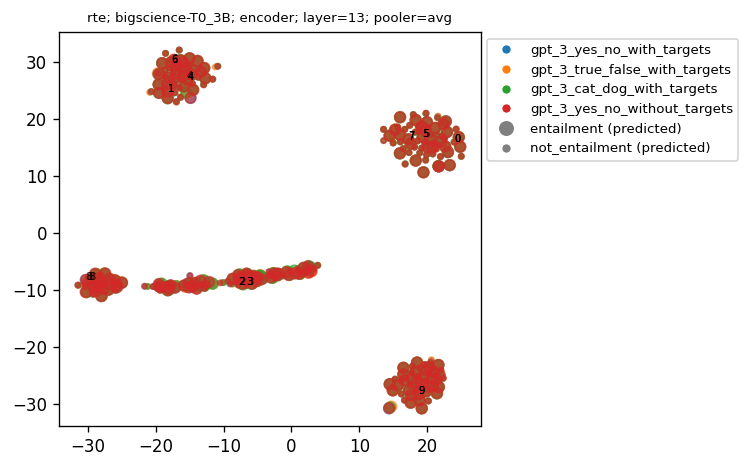

(1108, 2048)


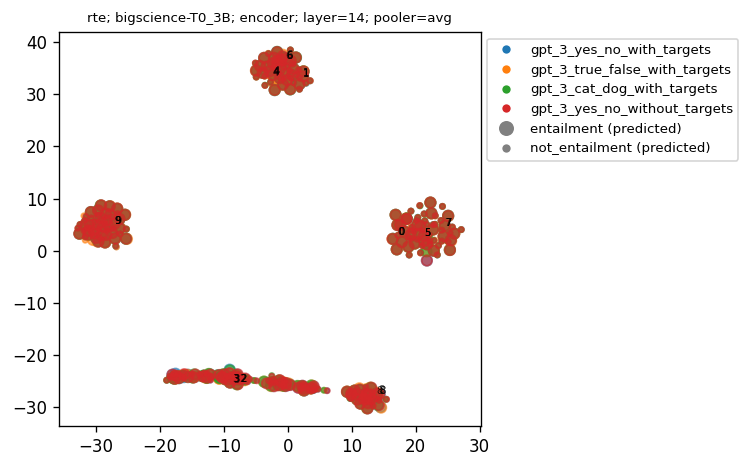

(1108, 2048)


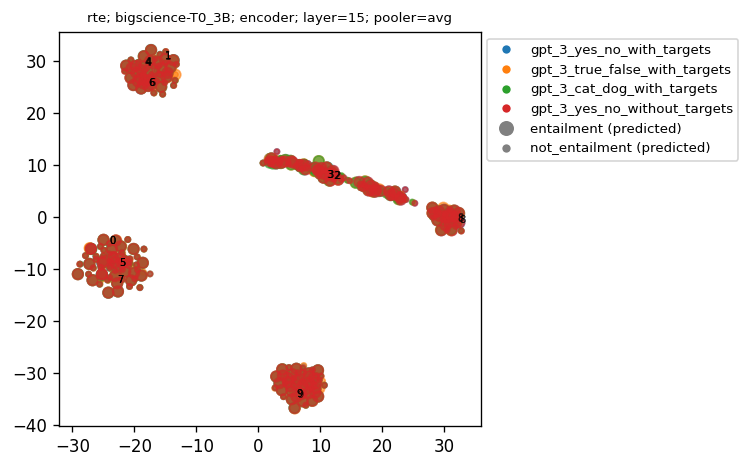

(1108, 2048)


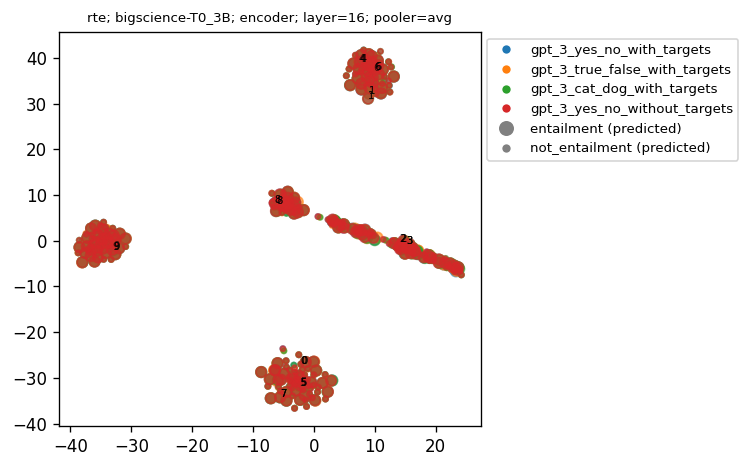

(1108, 2048)


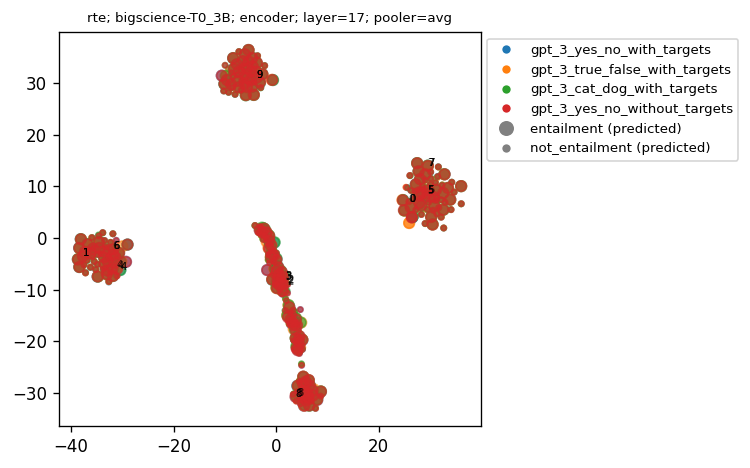

(1108, 2048)


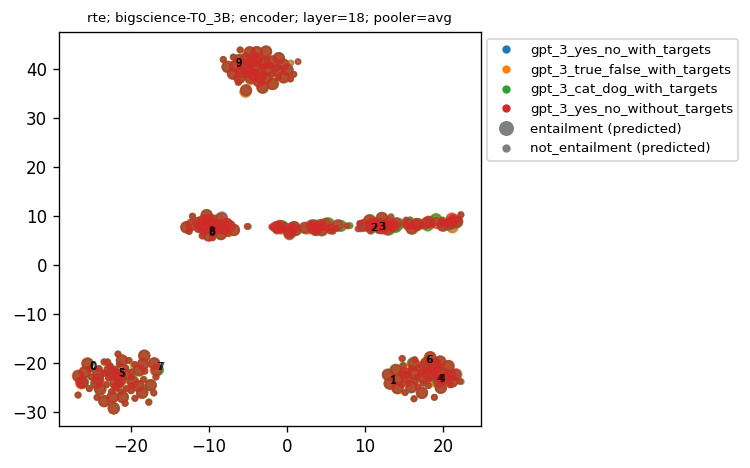

(1108, 2048)


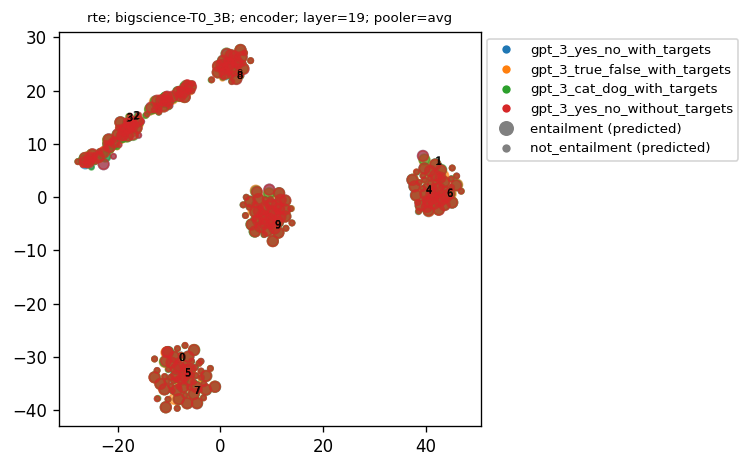

(1108, 2048)


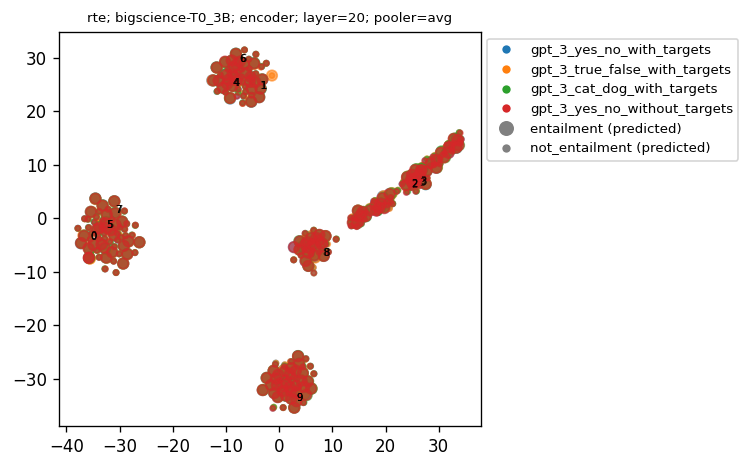

(1108, 2048)


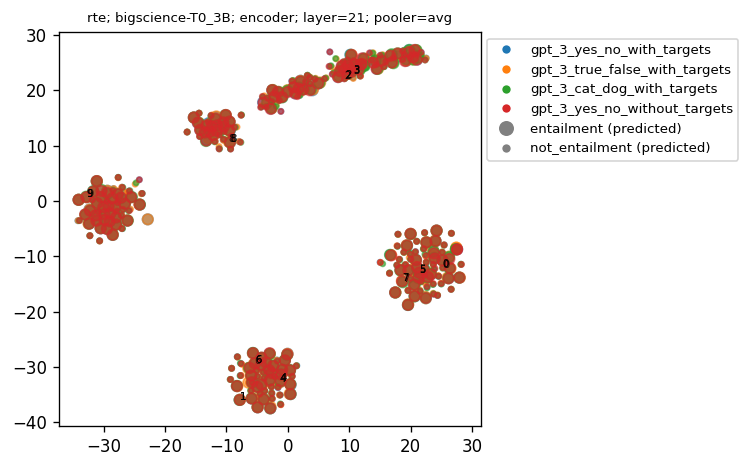

(1108, 2048)


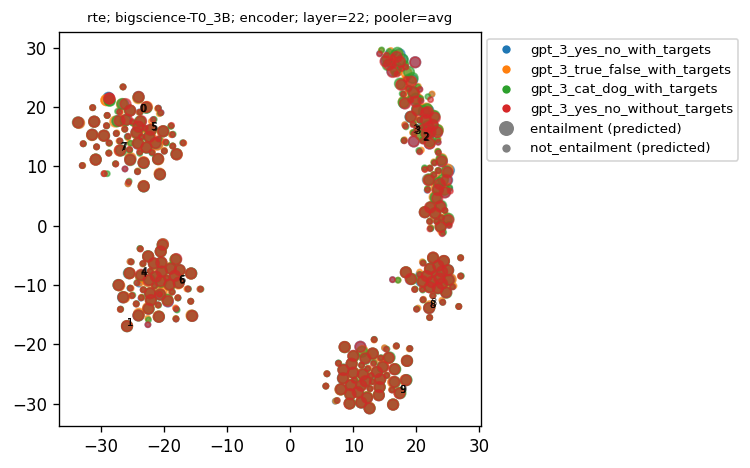

(1108, 2048)


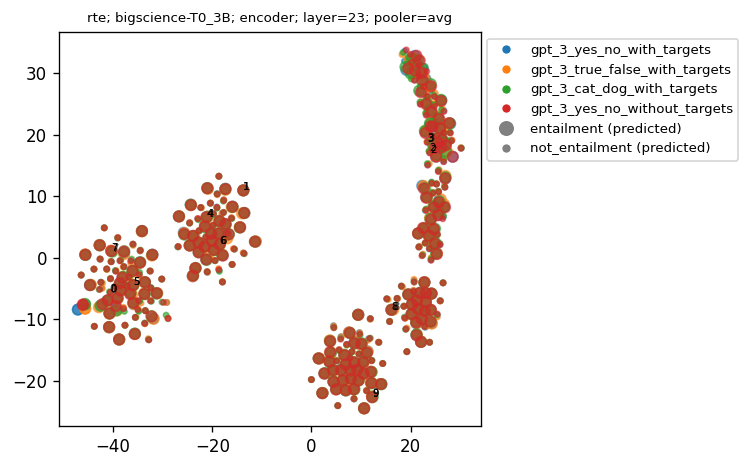

(1108, 2048)


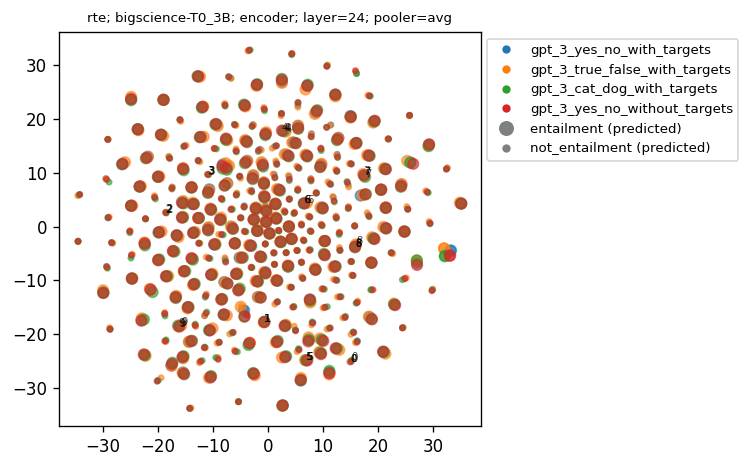

In [54]:
# for layer in range(0, 1):
# for layer in range(0, 5):
for layer in range(0, 25):
# for layer in range(24, 25):
    
    file_names, prompt_names = [], []
    
    for _, row in df.iterrows():
        if row['name'] in use_pattern:
            file_names.append(f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5")
            prompt_names.append(row['name'])
    
    # load hidden representations from hdf5 file
    representations = None
    n_sequences = 0

    for file_name in file_names:
        hidden_representations = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)
        n_sequences = hidden_representations.shape[0]

        if representations is None:
            representations = hidden_representations
        else:
            representations = np.concatenate((representations, hidden_representations), axis=0)

    print(representations.shape)

    # compute t-SNE embeddings
    X = TSNE(
        n_components=2, 
        perplexity=100, 
        init='random', # random or pca
        learning_rate=200,
        n_iter=1000
    ).fit_transform(representations)

    # plot t-SNE embeddings
    fig, axes = plt.subplots(1, 1, figsize=(5.5,4), dpi=120)
    legend_elements= []

    cmap = matplotlib.cm.get_cmap('tab10')
    # cmap = matplotlib.cm.get_cmap('tab20')
    colors = cmap.colors

    for idx, file_name in enumerate(file_names):
        # create a scatter plot for samples from each pattern
        x, y = X[n_sequences*idx:n_sequences*(idx + 1), 0], X[n_sequences*idx:n_sequences*(idx + 1), 1]

        # change size according to label
        if marker_size == 'ground-truth':
            labels = df_inputs[prompt_names[idx]]['label'].values
            sizes = [40.0 if l == 'entailment' else 10.0 for l in labels]
        elif marker_size == 'predicted':
            labels = df_inputs[prompt_names[idx]]['prediction'].values
            sizes = [40.0 if l == 'entailment' else 10.0 for l in labels]

        # change size according to predicted target
        labels = df_inputs[prompt_names[idx]]['label'].values
        sizes = [40.0 if l == 'entailment' else 10.0 for l in labels]

        axes.scatter(x, y, alpha=0.6, color=colors[idx], s=sizes)

        # create legend element manually
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=prompt_names[idx], markerfacecolor=colors[idx], markersize=6))

        # annotate scatter plot with text
        samles_indices = np.random.choice(range(n_sequences), size=20)
        # for i, txt in enumerate(list(range(n_sequences))): # annotate all samples
        # for i, txt in enumerate(samles_indices): # annotate randomly choosen samples
        for i, txt in enumerate(range(10)): # annotate first 10 samples
            axes.annotate(txt, (x[i], y[i]), alpha=0.7, fontsize=6)

    axes.set_title(f"{task}; {model}; {module}; layer={layer}; pooler=avg", fontsize=8)

   # Shrink current axis by 20%
    box = axes.get_position()
    axes.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    # ground-truth labels
    if marker_size == 'ground-truth':
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='entailment', markerfacecolor='gray', markersize=10))
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='not_entailment', markerfacecolor='gray', markersize=6))

    # predicted labels
    elif marker_size == 'predicted':
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='entailment (predicted)', markerfacecolor='gray', markersize=10))
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='not_entailment (predicted)', markerfacecolor='gray', markersize=6))
    axes.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=False, fontsize=8)

    plt.tight_layout()

    plt.show()
    plt.close();

In [55]:
df

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No","0, 1",False
1,gpt_3_true_false_with_targets,{premise} Question: {hypothesis} True or False?,instructive,True,"▁True, ▁False","0, 1",False
2,gpt_3_cat_dog_with_targets,{premise} Question: {hypothesis} Cat or Dog?,instructive,True,"▁Cat, ▁Dog","0, 1",False
3,gpt_3_yes_no_without_targets,{premise} Question: {hypothesis}?,instructive,False,"▁Yes, ▁No","0, 1",False
